# Full ANN classification example using EMVIC_3C dataset

In [1]:
import pandas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from collections import Counter

### Load data

In [2]:
dataframe = pandas.read_csv("emvic_3c.csv")
dataset = dataframe.values
samples = dataset[:,1:]
labels = dataset[:,0]
samples = np.array(samples)
labels = np.array(labels)
labels = labels.astype(str)

print("Class distribution:")
print(Counter(labels))

Class distribution:
Counter({'a25': 104, 'a41': 39, 'a37': 11})


### Choose k best attributes

In [3]:
from sklearn.feature_selection import SelectKBest
newSamples = SelectKBest(k=100).fit_transform(samples, labels)
print(newSamples.shape) 
samples = newSamples

(154, 100)


C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [    0     1     2     3     4     5     6     7 16376 16377 16378 16379
 16380 16381 16382 16383] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Calculate weights for unbalanced classes

In [4]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(labels),y=labels)
d_class_weights = dict(enumerate(class_weights))
print("Class weights:",d_class_weights)

Class weights: {0: 0.4935897435897436, 1: 4.666666666666667, 2: 1.3162393162393162}


### Normalize samples

In [5]:
from sklearn.preprocessing import normalize
print(samples[0,:10])
samples = normalize(samples)
print(samples[0,:10])

[3.1622776601683795 4.0 3.6055512754639887 406.0 444.0 475.0 500.0 508.0
 504.0 499.0]
[0.00050958 0.00064458 0.00058101 0.06542448 0.07154795 0.07654342
 0.08057202 0.08186117 0.08121659 0.08041087]


### Convert to one-hot encoding

In [6]:
print("Shape before",labels.shape)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Shape after",labels.shape)
classesNum = labels.shape[1]
print ("Classes: {}".format(classesNum))

Shape before (154,)
Shape after (154, 3)
Classes: 3


### Division into training and test samples

In [7]:
from sklearn.model_selection._split import train_test_split
(trainSamples, testSamples, trainLabels, testLabels) = train_test_split(samples, labels, test_size=0.25, random_state=42)
print('Train samples',len(trainSamples))
print('Test samples',len(testSamples))


Train samples 115
Test samples 39


### Create the model

In [8]:
model = Sequential()
model.add(Dense(250, activation='sigmoid',input_dim=100))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(classesNum, activation='softmax'))

## loss function depends on the number of classes!
loss='categorical_crossentropy'    
model.compile(loss=loss, optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               25250     
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 753       
Total params: 151,503
Trainable params: 151,503
Non-trainable params: 0
_________________________________________________________________


### Fit and validate the model

In [9]:
EPOCHS=100
BATCH=50
H = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
              ,class_weight=d_class_weights
              ,validation_data=(testSamples,testLabels)
              #,validation_split=0.1
              )
mlpResults = model.predict(testSamples)

Epoch 1/100
3/3 [==============================] - 0s 116ms/step - loss: 1.1663 - accuracy: 0.1652 - val_loss: 0.9040 - val_accuracy: 0.6667
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1557 - accuracy: 0.6783 - val_loss: 1.0473 - val_accuracy: 0.6667
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0851 - accuracy: 0.3565 - val_loss: 1.2361 - val_accuracy: 0.0769
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1009 - accuracy: 0.0870 - val_loss: 1.2354 - val_accuracy: 0.2564
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0926 - accuracy: 0.2522 - val_loss: 1.0526 - val_accuracy: 0.6667
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0815 - accuracy: 0.6783 - val_loss: 0.9839 - val_accuracy: 0.6667
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0967 - accuracy: 0.6696 - val_loss: 1.0312 - val_accuracy: 0.6667
Epoch 8/100
3/3 [==

### Print results

In [10]:
print(confusion_matrix(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), mlpResults.argmax(axis=1),target_names=lb.classes_))
mlpAcc = accuracy_score(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)) 
print("MLP Accuracy: {:.2f}".format(mlpAcc))

[[23  1  2]
 [ 0  3  0]
 [ 1  4  5]]
              precision    recall  f1-score   support

         a25       0.96      0.88      0.92        26
         a37       0.38      1.00      0.55         3
         a41       0.71      0.50      0.59        10

    accuracy                           0.79        39
   macro avg       0.68      0.79      0.68        39
weighted avg       0.85      0.79      0.81        39

MLP Accuracy: 0.79


In [11]:
H.history

{'loss': [1.1663168668746948,
  1.1557486057281494,
  1.0850735902786255,
  1.100936770439148,
  1.0926393270492554,
  1.0814917087554932,
  1.096727967262268,
  1.069006323814392,
  1.0631515979766846,
  1.0519044399261475,
  1.0456597805023193,
  1.0302448272705078,
  1.024661898612976,
  1.027722954750061,
  0.9989261627197266,
  0.9680162668228149,
  0.9724425077438354,
  0.9158079028129578,
  0.8652148246765137,
  0.8335399031639099,
  0.8028504848480225,
  0.7518264055252075,
  0.7240734696388245,
  0.7087610363960266,
  0.7052804231643677,
  0.7018767595291138,
  0.6847972273826599,
  0.6926490664482117,
  0.6983151435852051,
  0.6737829446792603,
  0.6751179099082947,
  0.6739017367362976,
  0.6710500717163086,
  0.67549729347229,
  0.6752622723579407,
  0.6649720668792725,
  0.6654884219169617,
  0.6661636233329773,
  0.6628015637397766,
  0.6627354025840759,
  0.6621761322021484,
  0.657939076423645,
  0.6659685969352722,
  0.6749429702758789,
  0.6693334579467773,
  0.655607

### Show history

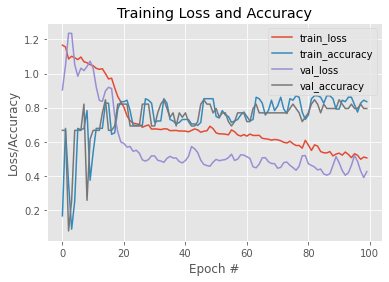

In [12]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Decision Tree model for comparison

In [13]:
from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier()
treemodel.fit(trainSamples, trainLabels)
treeResults = treemodel.predict(testSamples)    
print(confusion_matrix(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
treeAcc = accuracy_score(testLabels.argmax(axis=1), treeResults.argmax(axis=1)) 
print("Tree Accuracy: {:.2f}".format(treeAcc))

[[25  0  1]
 [ 1  0  2]
 [ 0  2  8]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.00      0.00      0.00         3
           2       0.73      0.80      0.76        10

    accuracy                           0.85        39
   macro avg       0.56      0.59      0.57        39
weighted avg       0.83      0.85      0.84        39

Tree Accuracy: 0.85


### kNN for comparison

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier()
knnmodel.fit(trainSamples, trainLabels)
knnResults = knnmodel.predict(testSamples)    
print(confusion_matrix(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
knnAcc = accuracy_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1)) 
print("kNN Accuracy: {:.2f}".format(knnAcc))

[[25  0  1]
 [ 1  0  2]
 [ 3  0  7]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.00      0.00      0.00         3
           2       0.70      0.70      0.70        10

    accuracy                           0.82        39
   macro avg       0.52      0.55      0.54        39
weighted avg       0.75      0.82      0.79        39

kNN Accuracy: 0.82


C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
